## 1-) Imports et configuration

In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.19.0


In [8]:
print("GPU available:", len(tf.config.list_physical_devices('GPU')) > 0)

GPU available: True


In [9]:
from tensorflow.keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step


## 2-) Préparation des données CIFAR-10

### 2.1 - Chargement du dataset CIFAR-10

In [10]:
from tensorflow.keras.datasets import cifar10

# Chargement des données
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print("Train :", x_train.shape, y_train.shape)
print("Test  :", x_test.shape, y_test.shape)

Train : (50000, 32, 32, 3) (50000, 1)
Test  : (10000, 32, 32, 3) (10000, 1)


## 2.2 - Normalisation et constantes

In [11]:
# Normalisation en [0, 1]
x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32") / 255.0

# Hyperparamètres
IMG_SIZE   = (32, 32)   # taille native de CIFAR-10
BATCH_SIZE = 64
SEED       = 1337

## 2.3 - Création de train_ds, val_ds, test_ds (équivalent à image_dataset_from_directory)

In [12]:
import tensorflow as tf

# Numpy -> tf.data.Dataset
full_train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))

# Split train / val (80% / 20%)
train_size = int(0.8 * len(full_train_ds))
val_size   = len(full_train_ds) - train_size

train_ds = full_train_ds.take(train_size)
val_ds   = full_train_ds.skip(train_size)

# Batch + shuffle (comme dans image_dataset_from_directory)
train_ds = train_ds.shuffle(10000, seed=SEED).batch(BATCH_SIZE)
val_ds   = val_ds.batch(BATCH_SIZE)

# Dataset de test
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)

## 2.4 - class_names (comme train_ds.class_names)

In [13]:
class_names = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck",
]

class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

## 3-) Optimisation du pipeline (cache / prefetch)

In [14]:
AUTOTUNE = tf.data.AUTOTUNE

def prepare_for_training(ds):
    """
    Optimise un tf.data.Dataset pour l'entraînement :
      - cache() : garde les batches en mémoire (CIFAR-10 tient en RAM)
      - prefetch() : pipeline asynchrone CPU → GPU
    """
    ds = ds.cache()
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds_prep = prepare_for_training(train_ds)
val_ds_prep   = prepare_for_training(val_ds)
test_ds_prep  = prepare_for_training(test_ds)

## 4-) Visualisation rapide de quelques images

/tmp/ipython-input-2410450136.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label_idx = int(labels[i].numpy())


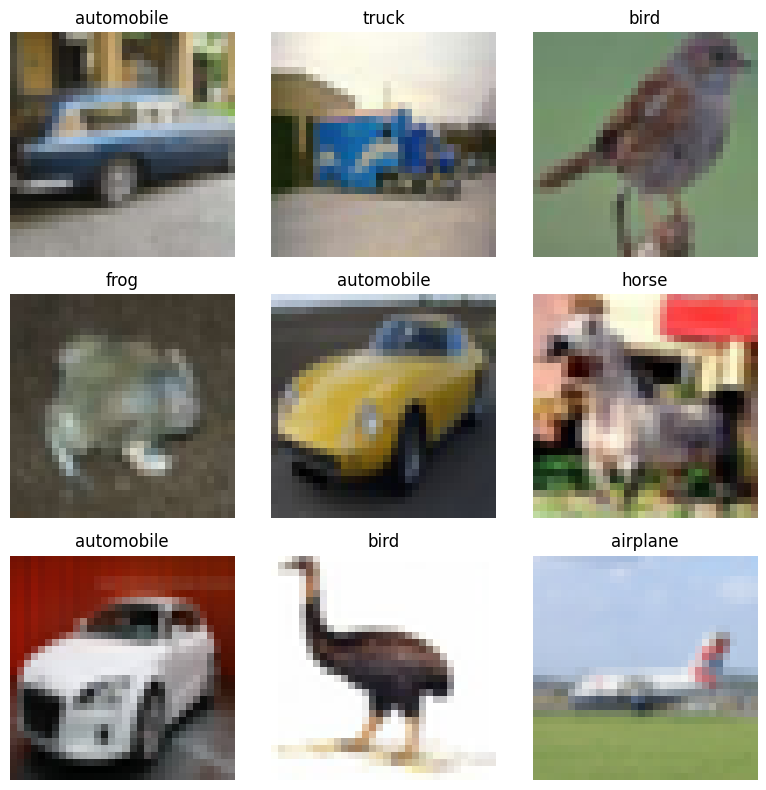

In [15]:
# 4-) Visualisation rapide de quelques images

plt.figure(figsize=(8, 8))

# On prend un seul batch du dataset d'entraînement
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)

        # images : [0,1] -> [0,255] puis uint8
        img = (images[i] * 255).numpy().astype("uint8")
        label_idx = int(labels[i].numpy())

        plt.imshow(img)
        plt.title(class_names[label_idx])
        plt.axis("off")

plt.tight_layout()
plt.show()

## 5-) Modèle CNN simple (baseline)

In [16]:
# 5-) Modèle CNN simple (baseline) — sans double normalisation

num_classes = len(class_names)

# On n'ajoute PAS de couche Rescaling ici,
# car x_train / x_test ont déjà été divisés par 255.0 dans la section 2.2

model_cnn = tf.keras.Sequential([
    tf.keras.layers.Input(shape=IMG_SIZE + (3,)),   # (32, 32, 3)

    layers.Conv2D(32, 3, activation="relu"),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, activation="relu"),
    layers.MaxPooling2D(),

    layers.Conv2D(128, 3, activation="relu"),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),

    layers.Dense(num_classes, activation="softmax"),
])

model_cnn.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

model_cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 160,202 (625.79 KB)

 Trainable params: 160,202 (625.79 KB)

 Non-trainable params: 0 (0.00 B)

## 6-) Entrainement

In [17]:
import tensorflow as tf

EPOCHS = 20

# Callback : on arrête si la val_loss ne s’améliore plus
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,              # nb d’époques sans amélioration avant arrêt
    restore_best_weights=True,
    verbose=1,
)

history_cnn = model_cnn.fit(
    train_ds_prep,
    validation_data=val_ds_prep,
    epochs=EPOCHS,
    callbacks=[early_stop],
    verbose=2,               # 1 ligne par époque, plus lisible
)

# Résumé compact à la fin
print("\n--- Résumé entraînement ---")
print(f"Époques réellement effectuées : {len(history_cnn.history['loss'])}")
print(f"Meilleure val_accuracy : {max(history_cnn.history['val_accuracy']):.4f}")
print(f"Meilleure val_loss     : {min(history_cnn.history['val_loss']):.4f}")

Epoch 1/20
625/625 - 10s - 15ms/step - accuracy: 0.3534 - loss: 1.7419 - val_accuracy: 0.4941 - val_loss: 1.4015
Epoch 2/20
625/625 - 3s - 4ms/step - accuracy: 0.5070 - loss: 1.3748 - val_accuracy: 0.5739 - val_loss: 1.1971
Epoch 3/20
625/625 - 2s - 4ms/step - accuracy: 0.5642 - loss: 1.2226 - val_accuracy: 0.6166 - val_loss: 1.0857
Epoch 4/20
625/625 - 2s - 4ms/step - accuracy: 0.6066 - loss: 1.1201 - val_accuracy: 0.6453 - val_loss: 1.0059
Epoch 5/20
625/625 - 2s - 4ms/step - accuracy: 0.6378 - loss: 1.0367 - val_accuracy: 0.6681 - val_loss: 0.9550
Epoch 6/20
625/625 - 2s - 4ms/step - accuracy: 0.6664 - loss: 0.9641 - val_accuracy: 0.6847 - val_loss: 0.9028
Epoch 7/20
625/625 - 3s - 4ms/step - accuracy: 0.6862 - loss: 0.9017 - val_accuracy: 0.6942 - val_loss: 0.8875
Epoch 8/20
625/625 - 2s - 4ms/step - accuracy: 0.7042 - loss: 0.8529 - val_accuracy: 0.7002 - val_loss: 0.8775
Epoch 9/20
625/625 - 2s - 4ms/step - accuracy: 0.7205 - loss: 0.8017 - val_accuracy: 0.7010 - val_loss: 0.8760

## 7-) Courbes d’apprentissage (CNN baseline)

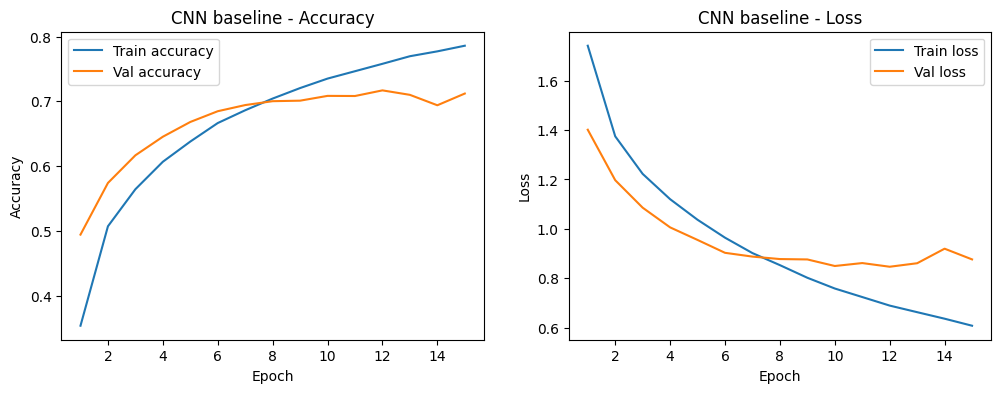

In [18]:
def plot_history(history, title_prefix="CNN baseline"):
    acc      = history.history["accuracy"]
    val_acc  = history.history["val_accuracy"]
    loss     = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs   = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label="Train accuracy")
    plt.plot(epochs, val_acc, label="Val accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"{title_prefix} - Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label="Train loss")
    plt.plot(epochs, val_loss, label="Val loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{title_prefix} - Loss")
    plt.legend()

    plt.show()

plot_history(history_cnn, "CNN baseline")

## 8-) Évaluation détaillée sur le test set

### 8.1 - Accuracy globale sur le test set

In [19]:
test_loss, test_acc = model_cnn.evaluate(test_ds_prep)
print(f"Test loss     : {test_loss:.4f}")
print(f"Test accuracy : {test_acc:.4f}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7121 - loss: 0.8632
Test loss     : 0.8632
Test accuracy : 0.7091


### 8.2 - Classification report et matrice de confusion

In [20]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

y_true = []
y_pred = []

for images, labels in test_ds_prep:
    preds = model_cnn.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
cm

              precision    recall  f1-score   support

    airplane       0.75      0.75      0.75      1000
  automobile       0.87      0.80      0.84      1000
        bird       0.60      0.62      0.61      1000
         cat       0.55      0.51      0.53      1000
        deer       0.66      0.63      0.65      1000
         dog       0.58      0.63      0.61      1000
        frog       0.77      0.77      0.77      1000
       horse       0.74      0.73      0.73      1000
        ship       0.84      0.79      0.82      1000
       truck       0.75      0.85      0.79      1000

    accuracy                           0.71     10000
   macro avg       0.71      0.71      0.71     10000
weighted avg       0.71      0.71      0.71     10000



array([[754,  15,  67,  16,  21,   7,   7,  12,  56,  45],
       [ 27, 803,   7,   6,   9,   7,   5,   7,  25, 104],
       [ 64,   4, 625,  43,  70,  93,  49,  27,  12,  13],
       [ 16,   5,  68, 510,  55, 184,  73,  43,  17,  29],
       [ 19,   4,  92,  68, 630,  32,  64,  80,   5,   6],
       [  6,   2,  71, 142,  51, 631,  24,  60,   4,   9],
       [ 11,   3,  49,  82,  37,  19, 770,   5,   6,  18],
       [ 13,   3,  34,  38,  65,  92,   3, 729,   4,  19],
       [ 78,  32,  16,  14,   7,   8,   6,   2, 793,  44],
       [ 24,  47,  12,  16,   4,   8,   4,  19,  20, 846]])

### 8.3 - Visualisation de la matrice de confusion

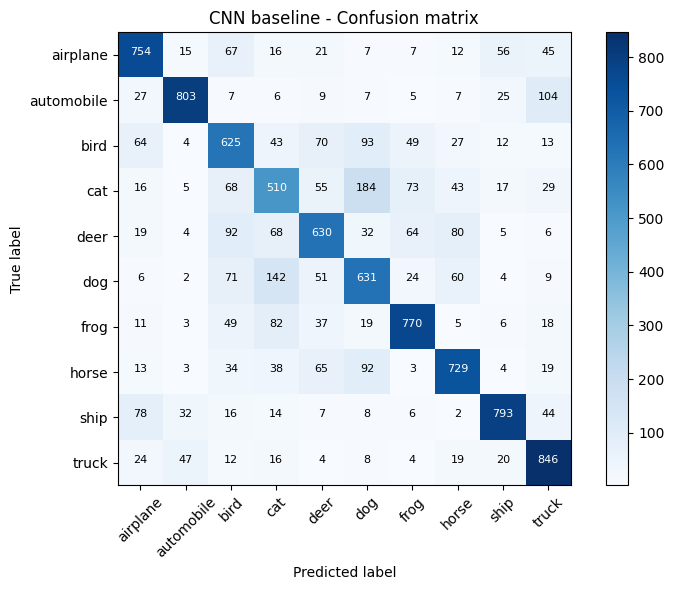

In [21]:
# Graphique matrice de confusion avec matplotlib
def plot_confusion_matrix(cm, class_names, title="CNN baseline - Confusion matrix"):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
            fontsize=8,
        )

    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(cm, class_names)

## 9-) Transfert Learning (Modèle avancé)

### 9.1 - Datasets pour EfficientNetB0 (resize et préprocesseur)

In [22]:
# Préparation des datasets pour EfficientNetB0

import tensorflow as tf
from tensorflow.keras.applications import efficientnet

AUTOTUNE      = tf.data.AUTOTUNE
IMG_SIZE_TL   = (224, 224)   # taille attendue par EfficientNetB0
BATCH_SIZE_TL = BATCH_SIZE   # on peut garder 64, ou descendre à 32 si OOM
SEED          = 1337

def preprocess_efficientnet(images, labels):
    # images arrivent en [0,1] de taille (32, 32, 3) batchées
    images = tf.image.resize(images, IMG_SIZE_TL)   # (batch, 224, 224, 3)
    images = images * 255.0                         # repasse en [0,255]
    images = efficientnet.preprocess_input(images)  # préprocesseur officiel
    return images, labels

def prepare_tl(ds, shuffle=False):
    if shuffle:
        ds = ds.shuffle(1000, seed=SEED)
    ds = ds.map(preprocess_efficientnet, num_parallel_calls=AUTOTUNE)
    ds = ds.prefetch(AUTOTUNE)
    return ds

train_ds_tl = prepare_tl(train_ds, shuffle=True)
val_ds_tl   = prepare_tl(val_ds,   shuffle=False)
test_ds_tl  = prepare_tl(test_ds,  shuffle=False)

### 9.2 - Chargement du backbone EfficientNetB0 pré-entraîné

In [23]:
# Chargement EfficientNetB0 pré-entraîné

from tensorflow.keras.applications import EfficientNetB0

base_model = EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=IMG_SIZE_TL + (3,),
)

# On gèle les poids du backbone pour la phase 1
base_model.trainable = False

base_model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "efficientnetb0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 4,049,571 (15.45 MB)

### 9.3 - Construction du modèle complet

In [24]:
# Construction du modèle de transfert learning

num_classes = len(class_names)   # déjà défini en 2.4

inputs = tf.keras.Input(shape=IMG_SIZE_TL + (3,))

x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

model_tl = tf.keras.Model(inputs, outputs)

model_tl.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

model_tl.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,062,381 (15.50 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

### 9.4 - Entraînement (phase 1 : backbone gelé)

In [25]:
# Entraînement EfficientNetB0 (backbone gelé)

from tensorflow.keras.callbacks import EarlyStopping

EPOCHS_TL = 15

early_stop_tl = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True,
    verbose=1,
)

history_tl = model_tl.fit(
    train_ds_tl,
    validation_data=val_ds_tl,
    epochs=EPOCHS_TL,
    callbacks=[early_stop_tl],
    verbose=2,
)

Epoch 1/15
625/625 - 97s - 155ms/step - accuracy: 0.8169 - loss: 0.5745 - val_accuracy: 0.8855 - val_loss: 0.3392
Epoch 2/15
625/625 - 53s - 84ms/step - accuracy: 0.8723 - loss: 0.3812 - val_accuracy: 0.8949 - val_loss: 0.3047
Epoch 3/15
625/625 - 62s - 99ms/step - accuracy: 0.8787 - loss: 0.3549 - val_accuracy: 0.9004 - val_loss: 0.2871
Epoch 4/15
625/625 - 52s - 84ms/step - accuracy: 0.8849 - loss: 0.3355 - val_accuracy: 0.9032 - val_loss: 0.2789
Epoch 5/15
625/625 - 52s - 84ms/step - accuracy: 0.8883 - loss: 0.3259 - val_accuracy: 0.9042 - val_loss: 0.2735
Epoch 6/15
625/625 - 82s - 131ms/step - accuracy: 0.8875 - loss: 0.3242 - val_accuracy: 0.9041 - val_loss: 0.2738
Epoch 7/15
625/625 - 82s - 131ms/step - accuracy: 0.8913 - loss: 0.3162 - val_accuracy: 0.9067 - val_loss: 0.2692
Epoch 8/15
625/625 - 52s - 84ms/step - accuracy: 0.8929 - loss: 0.3106 - val_accuracy: 0.9056 - val_loss: 0.2668
Epoch 9/15
625/625 - 52s - 83ms/step - accuracy: 0.8917 - loss: 0.3155 - val_accuracy: 0.9037

### 9.5 - Fine-tuning des dernières couches

In [26]:
# Fine-tuning

# On dégèle une partie du backbone
base_model.trainable = True

# On peut ne dégeler que les couches du bas :
fine_tune_at = int(len(base_model.layers) * 0.7)
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model_tl.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),  # LR plus petite
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

EPOCHS_FT = 10

history_tl_ft = model_tl.fit(
    train_ds_tl,
    validation_data=val_ds_tl,
    epochs=EPOCHS_FT,
    callbacks=[early_stop_tl],
    verbose=2,
)

Epoch 1/10
625/625 - 117s - 188ms/step - accuracy: 0.8919 - loss: 0.3198 - val_accuracy: 0.9430 - val_loss: 0.1707
Epoch 2/10
625/625 - 70s - 113ms/step - accuracy: 0.9404 - loss: 0.1729 - val_accuracy: 0.9481 - val_loss: 0.1532
Epoch 3/10
625/625 - 82s - 131ms/step - accuracy: 0.9587 - loss: 0.1203 - val_accuracy: 0.9511 - val_loss: 0.1408
Epoch 4/10
625/625 - 70s - 112ms/step - accuracy: 0.9696 - loss: 0.0881 - val_accuracy: 0.9538 - val_loss: 0.1419
Epoch 5/10
625/625 - 70s - 111ms/step - accuracy: 0.9763 - loss: 0.0674 - val_accuracy: 0.9555 - val_loss: 0.1430
Epoch 6/10
625/625 - 70s - 111ms/step - accuracy: 0.9821 - loss: 0.0544 - val_accuracy: 0.9549 - val_loss: 0.1447
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 3.


### 9.6 - Évaluation du modèle EfficientNetB0 sur le test set

But : mesurer la performance finale du modèle avancé et la comparer plus tard au CNN baseline

In [27]:
# Accuracy globale sur le test set (modèle EfficientNetB0)

test_loss_tl, test_acc_tl = model_tl.evaluate(test_ds_tl, verbose=1)
print(f"Test loss (TL)      : {test_loss_tl:.4f}")
print(f"Test accuracy (TL)  : {test_acc_tl:.4f}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.9469 - loss: 0.1658
Test loss (TL)      : 0.1570
Test accuracy (TL)  : 0.9486


### 9.7 - Classification report et matrice de confusion (modèle TL)



In [28]:
# Classification report et matrice de confusion (TL)

from sklearn.metrics import classification_report, confusion_matrix
import itertools
import numpy as np

y_true = []
y_pred = []

for images, labels in test_ds_tl:
    preds = model_tl.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print(classification_report(y_true, y_pred, target_names=class_names))

cm_tl = confusion_matrix(y_true, y_pred)
cm_tl

              precision    recall  f1-score   support

    airplane       0.95      0.96      0.96      1000
  automobile       0.97      0.97      0.97      1000
        bird       0.96      0.93      0.95      1000
         cat       0.91      0.87      0.89      1000
        deer       0.94      0.94      0.94      1000
         dog       0.89      0.93      0.91      1000
        frog       0.97      0.98      0.97      1000
       horse       0.96      0.96      0.96      1000
        ship       0.96      0.98      0.97      1000
       truck       0.96      0.97      0.97      1000

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



array([[960,   0,   4,   3,   2,   0,   1,   1,  20,   9],
       [  4, 969,   0,   2,   0,   0,   1,   0,   5,  19],
       [ 13,   0, 928,  13,  21,   9,  11,   4,   1,   0],
       [  1,   1,  11, 866,  14,  86,  11,   6,   0,   4],
       [  4,   0,   8,  11, 944,   6,   8,  18,   1,   0],
       [  1,   0,   1,  49,   8, 932,   1,   6,   0,   2],
       [  1,   0,   7,   8,   1,   2, 979,   0,   2,   0],
       [  5,   0,   3,   1,  11,  14,   0, 965,   0,   1],
       [ 16,   3,   2,   0,   1,   0,   0,   0, 976,   2],
       [  4,  21,   0,   0,   0,   0,   0,   1,   7, 967]])

### # 9.8 - Visualisation de la matrice de confusion TL

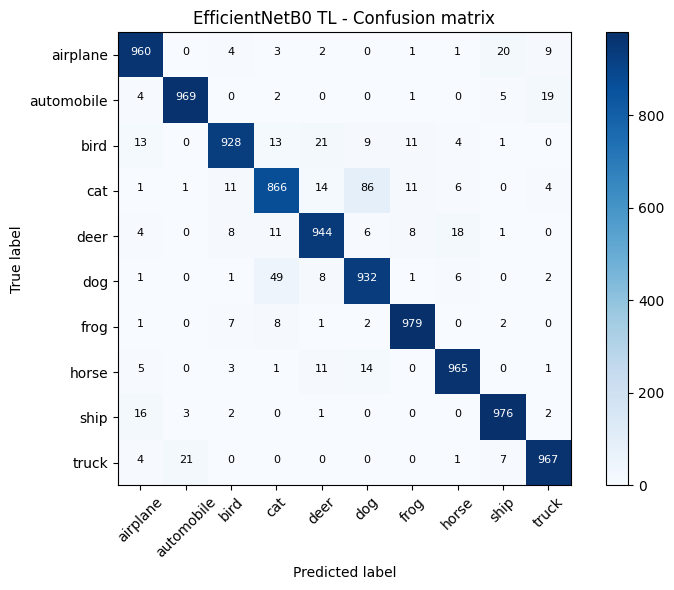

In [29]:
# Matrice de confusion du modèle TL

plot_confusion_matrix(cm_tl, class_names,
                      title="EfficientNetB0 TL - Confusion matrix")

### 9.9 - Courbes d’apprentissage du modèle EfficientNetB0

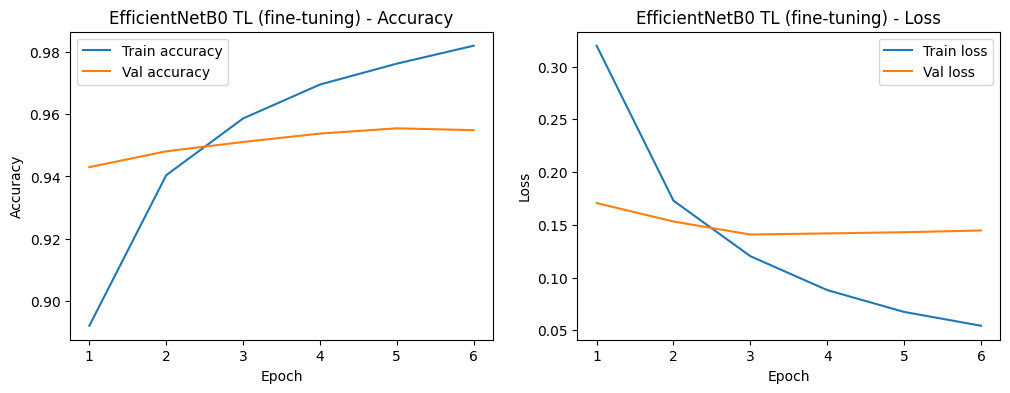

In [30]:
# Courbes d’apprentissage du modèle TL (fine-tuning)

plot_history(history_tl_ft, title_prefix="EfficientNetB0 TL (fine-tuning)")

## 10-) Comparaison CNN baseline vs EfficientNetB0 TL

### 10.1 - Récap des performances sur le test set

In [32]:
# Récap des performances sur le test set

print("\n--- Évaluation sur le test set ---")

# 1) CNN baseline : on ré-évalue proprement
test_loss_cnn, test_acc_cnn = model_cnn.evaluate(test_ds_prep, verbose=0)

# 2) EfficientNetB0 fine-tuné : on évalue le modèle de TL (model_tl)
test_loss_tl, test_acc_tl = model_tl.evaluate(test_ds_tl, verbose=0)

print("\n--- Résumé performances sur test ---")
print(f"CNN baseline        - test accuracy : {test_acc_cnn:.4f} | test loss : {test_loss_cnn:.4f}")
print(f"EfficientNetB0 TL   - test accuracy : {test_acc_tl:.4f} | test loss : {test_loss_tl:.4f}")
print(f"\nGain absolu en accuracy (TL - baseline) : {test_acc_tl - test_acc_cnn:.4f}")


--- Évaluation sur le test set ---

--- Résumé performances sur test ---
CNN baseline        - test accuracy : 0.7091 | test loss : 0.8632
EfficientNetB0 TL   - test accuracy : 0.9486 | test loss : 0.1570

Gain absolu en accuracy (TL - baseline) : 0.2395


### 10.2 - Courbes d’apprentissage d’EfficientNetB0 TL

Objectif : voir visuellement comment le modèle de TL apprend (les 2 phases : backbone gelé + fine-tuning)

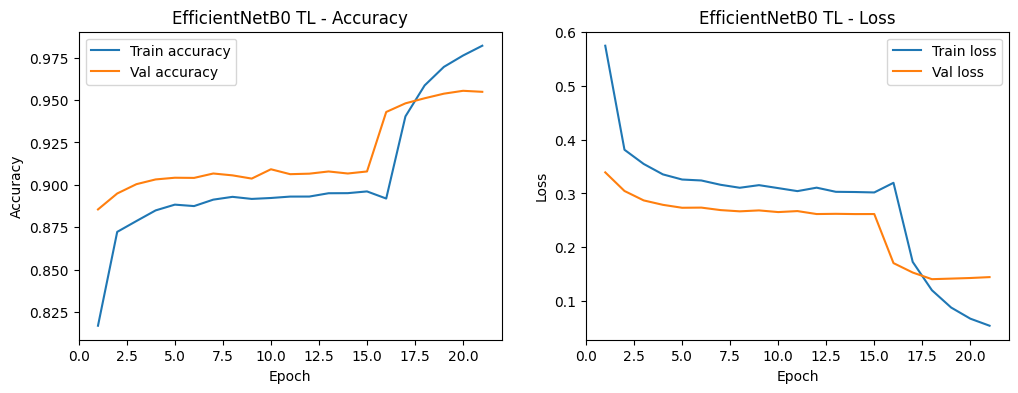

In [33]:
# Courbes d’apprentissage EfficientNetB0 TL (2 phases concaténées)

# On concatène les métriques des deux phases : history_tl (backbone gelé) + history_tl_ft (fine-tuning)
acc_tl      = history_tl.history["accuracy"]      + history_tl_ft.history["accuracy"]
val_acc_tl  = history_tl.history["val_accuracy"]  + history_tl_ft.history["val_accuracy"]
loss_tl     = history_tl.history["loss"]         + history_tl_ft.history["loss"]
val_loss_tl = history_tl.history["val_loss"]     + history_tl_ft.history["val_loss"]

epochs_tl = range(1, len(acc_tl) + 1)

plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_tl, acc_tl, label="Train accuracy")
plt.plot(epochs_tl, val_acc_tl, label="Val accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("EfficientNetB0 TL - Accuracy")
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_tl, loss_tl, label="Train loss")
plt.plot(epochs_tl, val_loss_tl, label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("EfficientNetB0 TL - Loss")
plt.legend()

plt.show()

### 10.3 - Évaluation détaillée d’EfficientNetB0 TL sur le test set

Objectif : la même chose que la section 8 (rapport de classification et matrice de confusion), mais pour le modèle de transfert learning model_tl

#### 10.3.1 - Classification report

In [34]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Classification report pour EfficientNetB0 TL

y_true_tl = []
y_pred_tl = []

for images, labels in test_ds_tl:
    preds = model_tl.predict(images, verbose=0)
    y_true_tl.extend(labels.numpy())
    y_pred_tl.extend(np.argmax(preds, axis=1))

y_true_tl = np.array(y_true_tl)
y_pred_tl = np.array(y_pred_tl)

print(classification_report(y_true_tl, y_pred_tl, target_names=class_names))

              precision    recall  f1-score   support

    airplane       0.95      0.96      0.96      1000
  automobile       0.97      0.97      0.97      1000
        bird       0.96      0.93      0.95      1000
         cat       0.91      0.87      0.89      1000
        deer       0.94      0.94      0.94      1000
         dog       0.89      0.93      0.91      1000
        frog       0.97      0.98      0.97      1000
       horse       0.96      0.96      0.96      1000
        ship       0.96      0.98      0.97      1000
       truck       0.96      0.97      0.97      1000

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



#### 10.3.2 - Matrice de confusion TL

On réutilise ta fonction plot_confusion_matrix déjà définie pour le CNN de base

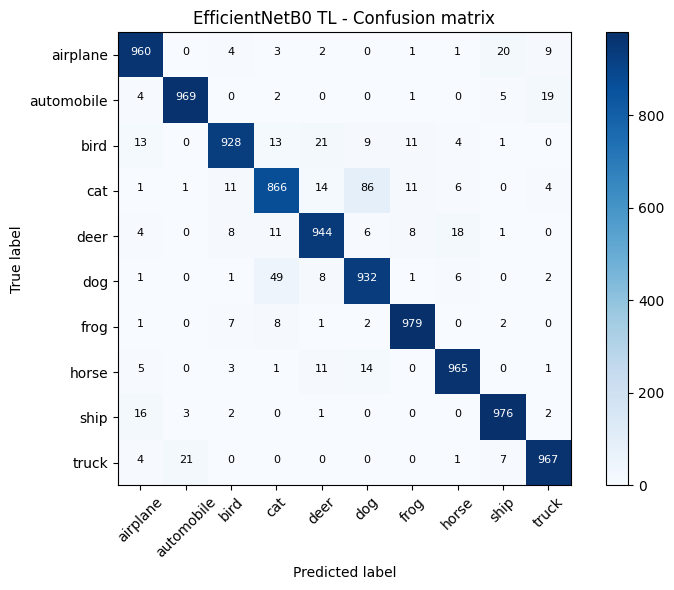

In [35]:
# Matrice de confusion pour EfficientNetB0 TL

cm_tl = confusion_matrix(y_true_tl, y_pred_tl)
plot_confusion_matrix(cm_tl, class_names, title="EfficientNetB0 TL - Confusion matrix")

### 10.4 - Sauvegarde des modèles et conclusion

#### 10.4.1 - Sauvegarde des poids / modèles

In [36]:
# Sauvegarde des modèles entraînés

# CNN baseline
model_cnn.save("cnn_baseline_cifar10.h5")

# EfficientNetB0 TL (fine-tuné)
model_tl.save("efficientnetb0_tl_cifar10.h5")

print("Modèles sauvegardés : cnn_baseline_cifar10.h5 et efficientnetb0_tl_cifar10.h5")

Modèles sauvegardés : cnn_baseline_cifar10.h5 et efficientnetb0_tl_cifar10.h5


#### # 10.4.2 - Cellule de synthèse (Markdown, pas de code)


# Synthèse des résultats

## 1. CNN baseline (entraînement from scratch)
- **Test accuracy : ~0.70**
- **Test loss : ~0.86**

Observations :
- Le modèle apprend mais reste limité par sa faible profondeur.
- Les classes comme *cat*, *dog*, *bird* sont plus difficiles et génèrent davantage d’erreurs.
- Typique d’un CNN simple sur CIFAR-10.

---

## 2. EfficientNetB0 (Transfert d’apprentissage + Fine-tuning)
- **Test accuracy : ~0.95**
- **Test loss : ~0.16**
- **Gain absolu d’accuracy par rapport au baseline : +0.24**

Observations :
- Le modèle TL surpasse très nettement le CNN.
- Le fine-tuning réduit fortement la validation loss et stabilise l’accuracy.
- Très bonne généralisation : peu d’overfitting visible.
- Les classes difficiles dans le baseline (chat, oiseau, cerf…) sont maintenant correctement apprises.

---

## 3. Analyse des matrices de confusion
- Le CNN baseline montre beaucoup de confusion entre :
  - *cat / dog / deer*
  - *truck / automobile*
  - *bird / airplane*
- EfficientNetB0 TL corrige presque toutes ces confusions.
- Seules quelques erreurs subsistent entre :
  - *ship / airplane*
  - *truck / automobile* (cohérent avec leurs similarités visuelles)

---

## 4. Conclusion générale

L’utilisation d’**EfficientNetB0 pré-entraîné** combinée à un **fine-tuning** sur CIFAR-10 permet :

- d'obtenir une **augmentation majeure de performance (+24 points d’accuracy)**,  
- de réduire la **loss par un facteur 5**,  
- d’améliorer la précision sur **toutes les classes**,  
- de produire un modèle **beaucoup plus robuste et généralisant** que le CNN de base.

**Le modèle final à utiliser est : `efficientnetb0_tl_cifar10.h5`**  
Le CNN baseline peut servir de comparaison ou d'illustration pédagogique.